Inspired by https://www.kaggle.com/bluevalhalla/fully-convolutional-network-lb-0-193

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

In [2]:
train = pd.read_json("_RawData/train.json/data/processed/train.json")
test = pd.read_json("_RawData/test.json/data/processed/test.json")

In [3]:
def get_images(df):
    '''Create 3-channel 'images'. Return rescale-normalised images.'''
    images = []
    for i, row in df.iterrows():
        # Formulate the bands as 75x75 arrays
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        # Rescale
        r = (band_1 - band_1.min()) / (band_1.max() - band_1.min())
        g = (band_2 - band_2.min()) / (band_2.max() - band_2.min())
        b = (band_3 - band_3.min()) / (band_3.max() - band_3.min())

        rgb = np.dstack((r, g, b))
        images.append(rgb)
    return np.array(images)

In [4]:
X = get_images(train)

In [5]:
y = to_categorical(train.is_iceberg.values,num_classes=2)

In [6]:
Xtr, Xv, ytr, yv = train_test_split(X, y, shuffle=False, test_size=0.20)

In [110]:
data_gen = ImageDataGenerator(
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            vertical_flip=True,
            horizontal_flip=True)

data_gen.fit(Xtr)

val_gen = ImageDataGenerator()
val_gen.fit(Xv)

In [7]:
def ConvBlock(model, layers, filters):
    '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [8]:
def create_model():
    '''Create the FCN and return a keras model.'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    model.add(Activation('softmax'))
    
    return model

In [120]:
# Create the model and compile
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 75, 75, 3)         0         
_________________________________________________________________
zero_padding2d_51 (ZeroPaddi (None, 77, 77, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_41 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
zero_padding2d_52 (ZeroPaddi (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 37, 37, 64)        18496     
__________

In [79]:
init_epo = 0
num_epo = 30
end_epo = init_epo + num_epo

In [123]:
epochs = 20
batch_size = 128

history = model.fit_generator(data_gen.flow(Xtr, ytr, batch_size=batch_size),
                     steps_per_epoch=len(Xtr) / batch_size,
                     epochs=epochs,
                     validation_data=val_gen.flow(Xv, yv, batch_size=batch_size, shuffle=False),
                     validation_steps = len(Xv) / batch_size)

Epoch 1/20
11/10 [================================] - 2s - loss: 0.2701 - acc: 0.8862 - val_loss: 0.3061 - val_acc: 0.8598
Epoch 2/20
11/10 [================================] - 2s - loss: 0.2701 - acc: 0.8840 - val_loss: 0.3246 - val_acc: 0.8131
Epoch 3/20
11/10 [================================] - 1s - loss: 0.2537 - acc: 0.8983 - val_loss: 0.3566 - val_acc: 0.7944
Epoch 4/20
11/10 [================================] - 1s - loss: 0.2449 - acc: 0.8933 - val_loss: 0.3145 - val_acc: 0.8037
Epoch 5/20
11/10 [================================] - 1s - loss: 0.2552 - acc: 0.8633 - val_loss: 0.3090 - val_acc: 0.8131
Epoch 6/20
11/10 [================================] - 1s - loss: 0.2487 - acc: 0.8990 - val_loss: 0.3007 - val_acc: 0.8255
Epoch 7/20
11/10 [================================] - 1s - loss: 0.2810 - acc: 0.8669 - val_loss: 0.3617 - val_acc: 0.7975
Epoch 8/20
11/10 [================================] - 1s - loss: 0.2770 - acc: 0.8662 - val_loss: 0.3008 - val_acc: 0.8692
Epoch 9/20
11/10

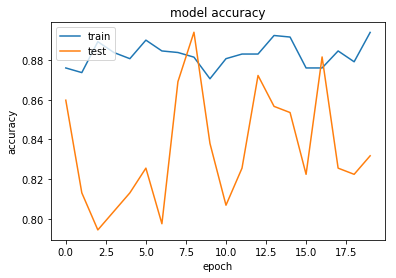

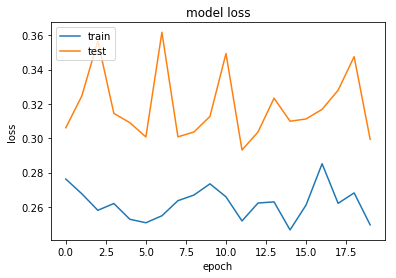

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print ('lr = {}'.format(K.get_value(model.optimizer.lr)))
history = model.fit(Xtr, ytr, validation_data=(Xv, yv), batch_size=32, epochs=end_epo, initial_epoch=init_epo)
init_epo += num_epo
end_epo = init_epo + num_epo

lr = 9.999999747378752e-05
Train on 1283 samples, validate on 321 samples
Epoch 1/30
1283/1283 [==============================] - 3s - loss: 0.5444 - acc: 0.7163 - val_loss: 0.7084 - val_acc: 0.3427
Epoch 2/30
1283/1283 [==============================] - 1s - loss: 0.4575 - acc: 0.7615 - val_loss: 0.6808 - val_acc: 0.6542
Epoch 3/30
1283/1283 [==============================] - 1s - loss: 0.3990 - acc: 0.8051 - val_loss: 0.6477 - val_acc: 0.6573
Epoch 4/30
1283/1283 [==============================] - 1s - loss: 0.3491 - acc: 0.8316 - val_loss: 0.6334 - val_acc: 0.6573
Epoch 5/30
1283/1283 [==============================] - 1s - loss: 0.3018 - acc: 0.8769 - val_loss: 0.6350 - val_acc: 0.6573
Epoch 6/30
1283/1283 [==============================] - 1s - loss: 0.2843 - acc: 0.8769 - val_loss: 0.6305 - val_acc: 0.6573
Epoch 7/30
1283/1283 [==============================] - 1s - loss: 0.2389 - acc: 0.9034 - val_loss: 0.6432 - val_acc: 0.6573
Epoch 8/30
1283/1283 [=============================

In [87]:
model.fit_generator(data_gen.flow(X, y, batch_size=32),
                     steps_per_epoch=len(X) / 32,
                     epochs=50)

Epoch 1/50
51/50 [==============================] - 3s - loss: 0.5528 - acc: 0.6984     
Epoch 2/50
51/50 [==============================] - 2s - loss: 0.4744 - acc: 0.7567     
Epoch 3/50
51/50 [==============================] - 2s - loss: 0.4195 - acc: 0.7959     
Epoch 4/50
51/50 [==============================] - 2s - loss: 0.4030 - acc: 0.7973     
Epoch 5/50
51/50 [==============================] - 2s - loss: 0.3568 - acc: 0.8254     
Epoch 6/50
51/50 [==============================] - 2s - loss: 0.3546 - acc: 0.8187     
Epoch 7/50
51/50 [==============================] - 2s - loss: 0.3408 - acc: 0.8285     
Epoch 8/50
51/50 [==============================] - 2s - loss: 0.3390 - acc: 0.8383     
Epoch 9/50
51/50 [==============================] - 2s - loss: 0.3357 - acc: 0.8272     
Epoch 10/50
51/50 [==============================] - 2s - loss: 0.3210 - acc: 0.8449     
Epoch 11/50
51/50 [==============================] - 2s - loss: 0.3139 - acc: 0.8382     
Epoch 12/50
51/50 [

In [88]:
X_test = get_images(test)
predict = model.predict(X_test)

In [89]:
submission = pd.DataFrame(test, columns=["id"])
submission["is_iceberg"] = predict[:, 1]

# test_func = lambda p: round(p["is_iceberg"], 4)
# submission["is_iceberg"] = test_func(submission)
submission["is_iceberg"] = submission["is_iceberg"].round(4)
submission.to_csv("submission_new.csv", float_format='%g', index = False)

In [90]:
# model.save_weights("01 - 2137.h5")

In [92]:
test_model = create_model()
test_model.load_weights("01 - 2137.h5")
test_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [93]:
test_model.fit_generator(data_gen.flow(X, y, batch_size=32),
                     steps_per_epoch=len(X) / 32,
                     epochs=1)

Epoch 1/1
51/50 [==============================] - 3s - loss: 0.2099 - acc: 0.9044     
